### Install Dependencies

In [ ]:
%pip install torch --quiet --quiet
%pip install coba --quiet --quiet
%pip install scipy --quiet --quiet
%pip install numpy --quiet --quiet
%pip install matplotlib --quiet --quiet

### TODO
+ Change all 'reward' names to 'loss'
+ Move MyRewardPredictor back into this notebook
+ Have the readme suggest how to make a new conda environment and install jupyter lab
+ Make sure to remove test.py from the repo
+ Rip out all coba dependencies from examples such as cb.Batch
+ Ensure numpy rather than ensure tensor for vectorization

### Run Demo

In [ ]:
import torch
import coba as cb
import numpy as np
from CappedIGW import CappedIGW
from ScaledL1Loss import MakeLosses
from PowerScheduler import PowerScheduler
from MyRewardPredictor import MyRewardPredictor
from UniformReferencePolicy import UniformReferencePolicy

#these values are specific to openml dataset 41540
n_context_dim, n_action_dim = 22, 1
tzero = 100
gamma_tzero = 1e-4
lr = 1e-2
batch_size = 8

fhat = MyRewardPredictor(
    numrff=1024,
    sigma=2e-1,
    in_features=n_context_dim+n_action_dim,
    opt_factory=lambda params: torch.optim.Adam(params,lr=lr),
    sched_factory=lambda opt: torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=PowerScheduler(tzero,-.5))
)

env = cb.Environments.cache_dir('.coba_cache').from_openml(data_id=41540).shuffle(seed=1).scale().filter(MakeLosses()).batch(batch_size)
lrn = CappedIGW(mu=UniformReferencePolicy(), 
                fhat=fhat, 
                tau=50, 
                gamma_scheduler = PowerScheduler(gamma_tzero,.5))

result = cb.Experiment(env,lrn).run()
result.plot_learners(y='reward'                  , span=2_000, xlim=(100,None))
result.plot_learners(y='reward_prediction_regret', span=2_000, xlim=(100,None))

2023-07-19 13:15:52 -- Experiment Started
2023-07-19 13:15:52 -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-07-19 13:15:52 -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2023-07-19 13:15:52 -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2023-07-19 13:15:57 -- Peeking at Environment 0... (5.21 seconds) (completed)


In [ ]:
import torch
import coba as cb
import numpy as np
from CappedIGW import CappedIGW
from ScaledL1Loss import MakeLosses
from PowerScheduler import PowerScheduler
from MyRewardPredictor import MyRewardPredictor
from UniformReferencePolicy import UniformReferencePolicy

#these values are specific to openml dataset 41540
n_context_dim, n_action_dim = 22, 1
tzero = 100
gamma_tzero = 1e-4
lr = 1e-2
batch_size = 8
n_batches = 2_500
n_processes = 7

if n_processes > 1:
    torch.set_num_threads(1)

fhats = [MyRewardPredictor(
    numrff=1024,
    sigma=s,
    in_features=n_context_dim+n_action_dim,
    opt_factory=lambda params: torch.optim.Adam(params,lr=lr),
    sched_factory=lambda opt: torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=PowerScheduler(tzero,-.5))
) for s in np.geomspace(5e-2,5e-1,6)]

fhats.append(MyRewardPredictor(
    numrff=1024,
    sigma=1e-1,
    in_features=n_context_dim+n_action_dim,
    opt_factory=lambda params: torch.optim.Adam(params,lr=lr),
    sched_factory=lambda opt: torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=PowerScheduler(tzero,-.5))
))

cb.Environments.cache_dir('.coba_cache')

env = cb.Environments.from_openml(data_id=41540,take=batch_size*n_batches).scale().filter(MakeLosses()).batch(batch_size)
lrn = [
    CappedIGW(mu=UniformReferencePolicy(), fhat=fhat, tau=50, gamma_scheduler = PowerScheduler(gamma_tzero,.5))
    for fhat in fhats
]

result = cb.Experiment(env,lrn).run(processes=n_processes)
result.plot_learners(y='reward'                  , span=2_000, xlim=(100,None))
result.plot_learners(y='reward_prediction_loss'  , span=2_000, xlim=(100,None))
result.plot_learners(y='reward_prediction_regret', span=2_000, xlim=(100,None))

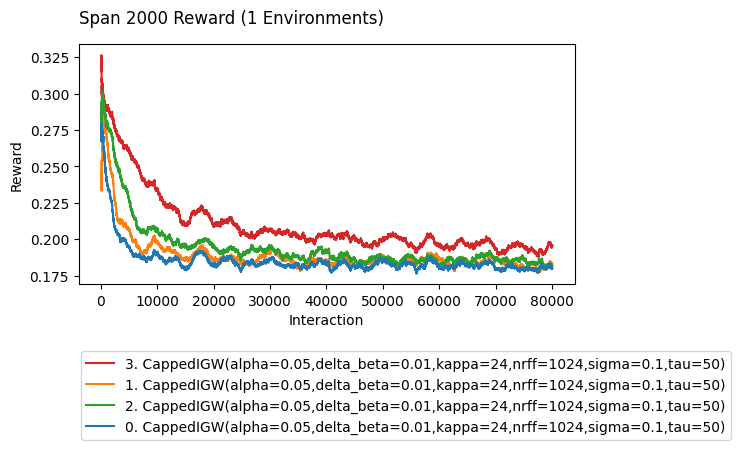

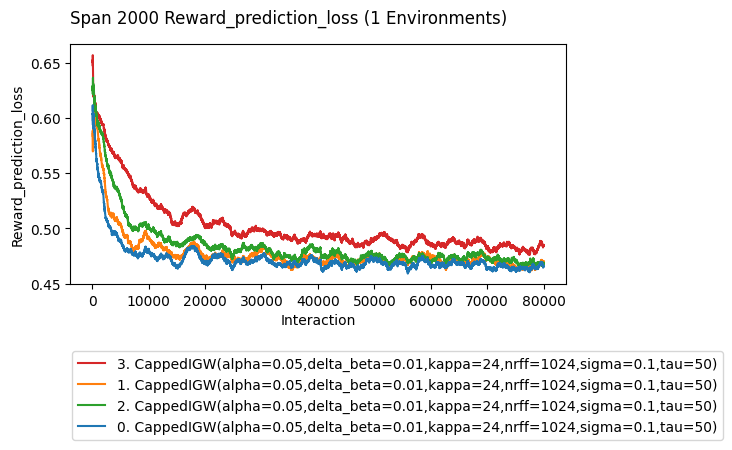

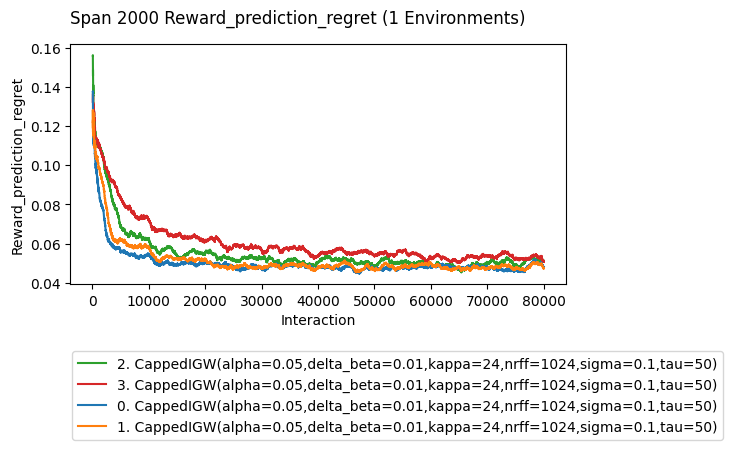

In [10]:
result.plot_learners(y='reward'                  , span=2000, xlim=(100,None))
result.plot_learners(y='reward_prediction_loss'  , span=2000, xlim=(100,None))
result.plot_learners(y='reward_prediction_regret', span=2000, xlim=(100,None))

In [ ]:
result.plot_learners()